In [ ]:
# Import the relevant libraries
from scipy import optimize
from scipy import signal
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import datetime
from datetime import date
from datetime import timedelta
import xarray as xr
import dask
import dask.array as da
import glob
import os
import time

# import from dictionary
from dictionaries import *

### Original dam optimization model ###

Created by John Methven

Cell also includes running_mean function which is called by damop_model.

In [ ]:
# original damop function
def damop_model(runoffarr, dt, catcharea, kappa, hmax, hmin, wmax, wmin, rmax, sigma):
    '''
    Implementation of the dam operation model of Hirsch et al (2014).
    Input: 
    :runoffarr  - input time series for runoff data
    :dt         - runoff accumulation interval per record
    :catcharea  - catchment area for the dam
    :kappa      - parameter relating reservoir depth to volume
    :hmax       - maximum water head (constraint on optimization)
    :hmin       - minimum water head
    :wmax       - maximum flow rate through turbines
    :wmin       - minimum flow rate to maintain some power generation
    :rmax       - maximum relief flow rate, bypassing turbines in flood
    :sigma      - operational efficiency of power generation by dam
    Output: 
    :inflow     - input time series for inflow to reservoir  
    :x          - output time series for water head at dam
    :w          - output solution for optimum flow rate through turbines
    :r          - output solution for relief flow rate
    :gout       - value of time integrated generation for optimum solution (MW-days)
    '''       
    print()
    print('damop_model has been called with the constraints:')
    print('wmax = ',wmax,'   wmin = ',wmin,'   hmax = ',hmax,'   hmin = ',hmin)
    #
    # Convert runoff data from units of m to an equivalent inflow in m^3 s^-1
    # Assume that the same runoff rate applies to the entire catchment area for dam
    #
    runoffave = np.mean(runoffarr)
    inflow = catcharea*runoffarr/dt
    n = len(inflow)
    inmax = max(inflow)
    #
    # Set parameter used to control computational mode using filter similar to Robert-Asselin
    # Recommend 0 because filter introduces an offset of W relative to I in optimization.
    #
    alpha = 0.0
    #
    # Apply running mean to the inflow data if required for smoother solution 
    # to the optimisation. Averaging window length = nwin.
    #
    nwin = 3
    inflow = running_mean(inflow, nwin)
    #
    # Scale mu so that the sum of generation over time points is approx one.
    # This gives a better numerical solution in the optimisation for max generation
    # by reducing numerical truncation error in the calculation.
    #
    mu = 1.0/(n*sigma*wmax*hmax)
    #
    # The dam management optimization model is set up in the mathematical form of a 
    # quadratic programming problem.
    # The only input time series is the inflow to the reservoir.
    # The model solves for the water head at the dam maximizing power generation.
    # This then gives the flow rate through the turbines.
    # However, contraints are applied on maximum and minimum water level 
    # and maximum/minimum flow rate through the turbines.
    #
    # The equation for generation can be written in the form
    # 
    # G = 0.5*H^T P H + q^T H
    #
    # where H is the head time series we are solving for (a 1-D array) and 
    # P is a matrix and q is also a 1-D time series (scaled inflow).
    # The notation ^T means the transpose of the matrix. 
    # Quadratic programming aims to minimize -G which is equivalent to max(G).
    #
    q = -mu*sigma*inflow
    umat = np.zeros((n, n))
    inmat = np.zeros((n, n))
    cmat = np.zeros((n, n))
    for i in range(n):
        umat[i, i] = 1
        inmat[i, i] = inflow[i]

    for j in range(n-2):
        i = j+1
        cmat[i, i-1] = -1 + 0.5*alpha
        cmat[i, i]   = -alpha
        cmat[i, i+1] = 1 + 0.5*alpha
    
    pscal = mu*sigma*(kappa/dt)*cmat
    wscal = -0.5*(kappa/dt)*cmat
    #
    # Set constraints on the water head at the dam: hmin <= h <= hmax
    # Optimization requires that constraints actually need to be applied in form:
    # Amat x <= b  (where in this problem the vector x is head time series, h).
    # For Amat x >= b it is necessary to re-arrange to -Amat x <= -b.
    # Therefore to apply hmin <= h <= hmax, the matrix Amat is the unit matrix.
    #
    hscal = umat
    hmaxcons = np.ones(n)*hmax
    hmincons = np.ones(n)*hmin    
    #
    # Set constraints on the flow rate 
    # based on the parameters Wmax, Rmax and Wmin.
    # The form of the contraints means that it must be applied to range of W*h:
    # Wmin*hmin <= W*h <= (Wmax+Rmax)*hmax
    #
    gscal = wscal + inmat
    gmaxcons = np.zeros(n)
    gmincons = np.zeros(n)
    for i in range(n):
        gmaxcons[i] = (wmax+rmax)*hmax
        gmincons[i] = wmin*0.5*(hmin+hmax)
    #
    # Construct a single matrix describing Amat and vector for constraint values b
    # in the form required by optimize.minimize
    #
    vmat = np.concatenate((gscal, -gscal, hscal, -hscal), axis=0)
    vcons = np.concatenate((gmaxcons, -gmincons, hmaxcons, -hmincons))
    
    print('Now apply quadratic minimization technique')
    
    def gen(x, sign=1.):
        return sign * (0.5*np.dot(x.T, np.dot(pscal, x)) + np.dot(q.T, x))
    
    def jac(x, sign=1.):
        return sign * (np.dot(x.T, pscal) + q.T)
    
    cons = {'type':'ineq',
            'fun':lambda x: vcons - np.dot(vmat, x),
            'jac':lambda x: -vmat}
    
    opt = {'disp':True, 'maxiter':100, 'ftol':1e-08}

    #
    # Obtain solution by minimization nouter times. Smooth the input first guess 
    # and results for head, h, which removes noise and any numerical instability in 
    # optimal solution for the flow rate time series, W.
    # Note that the minimize method does not always find a solution consistent 
    # with the contraints imposed (depending on the first guess data) and these
    # failed attempts are not included in the average solution.
    #
    nouter = 3
    istsuccess = 1
    ic = -1
    afac = 0.5
    xinit = hmax*(afac + 0.1*np.random.randn(n))
    nwin = min([41, 2*round(0.2*n)+1])
    print('running mean window length, nwin = ',nwin)
    xinit = running_mean(xinit, nwin)
    
    for io in range(nouter):
    #while istsuccess == 1:
        #
        # First guess values for x (water head).
        # Random variation on top of constant level.
        # Smooth to reduce 2-grid noise in input data.
        #
        ic = ic+1
        res_cons = optimize.minimize(gen, xinit, jac=jac, constraints=cons,
                                 method='SLSQP', options=opt)
        xup = res_cons['x']
        fup = res_cons['fun']  
        stexit = res_cons['status']
    
        if stexit != 4:
            if istsuccess == 1:
                x = xup
                x = running_mean(x, nwin)
                xinit = x
                f = fup
                print('Constrained optimization')
                print(res_cons)
                print('iter ',ic,' f = ',f)
                istsuccess = 0
            else:
                if (fup/f) < 2:
                    afac = float(ic+1)/nouter
                    x = afac*x + (1-afac)*xup
                    x = running_mean(x, nwin)
                    xinit = x
                    f = afac*f + (1-afac)*fup
                    print('iter ',ic,' f = ',f)
        if ic == nouter:
            print(nouter,' outer iterations finished without reaching result')
            istsuccess = 1
    # end outer loop
    
    #
    # Optimisation returns the head in variable x
    # Total flow rate ft = W+R is calculated from head and known inflow rate
    # Total flow is diverted into relief flow when it exceeds Wmax (and Rmax > 0)
    #
    ft = np.dot(wscal, x) + inflow
    w = np.copy(ft)
    r = np.zeros(n)
    excessflow = np.where(ft > wmax)
    if rmax > 0:
        w[excessflow] = wmax
        r[excessflow] = ft[excessflow]-wmax
    
    gout = -f
    
    return inflow, x, w, r, gout

# running mean function
def running_mean(xarr, nwin):
    '''
    Apply running mean filter through array
    Inputs:
        xarr    - array to filter
        nwin    - number of points in the filter window (odd number expected)
    Output:
        xfilt   - same length as xarr after application of filter
    '''
    n = len(xarr)
    xfilt = np.copy(xarr)
    ist = int(nwin/2)
    xconv = np.convolve(xarr, np.ones(nwin),'valid')/nwin
    nconv = len(xconv)
    xfilt[ist:n-ist] = xconv[:]
    xfilt[0:ist] = xconv[0]
    xfilt[n-ist:n] = xconv[nconv-1]
    
    return xfilt

### Updated dam optimization model ###

Used to call up damop_model with dictionaries containing values

Includes optional plotting call dependent on task name (e.g. Q1, Q2)

In [91]:
# updated dam operation model
def damop_model_UPDATED(params):
    '''
    Implementation of the dam operation model of Hirsch et al (2014).
    
    Inputs:
    params  - list of parameters for the model

    Outputs:
    inflow   - inflow rate to the dam (m^3 s^-1)
    x - head in the reservoir (m)
    w - flow rate through the dam (m^3 s^-1)
    r - flow rate through the relief channel (m^3 s^-1)
    gout - objective function value (negative of the total flow rate)                     
    '''
    # first import the constants from the dictionary
    catcharea = params['catchment_area'] # the area of the catchment (m^2)
    kappa = params['kappa'] # proportionality constant between resv. volume and head
    hmax = params['H_max'] # maximum safe water height in the reservoir (m)
    hmin = params['H_min'] # minimum safe water height in the reservoir (m)
    wmax = params['W_max'] # maximum safe flow rate through the dam (m^3 s^-1)
    wmin = params['W_min'] # minimum flow rate through the dam (m^3 s^-1)
    rmax = params['R_max'] # maximum flow rate through the relief channel avoiding turbines (m^3 s^-1)
    sigma = params['sigma'] # efficiency of power generation (proportion)

    # import the task flag and fig name
    task = params['task']
    fig_name = params['fig_name']

    # now we want to import the runoff data
    # first import the path for the netcdf point file
    path = params['path']
    # now import the data
    f = Dataset(path, 'r')
    # import runoff and time data
    # this part was updated with the help of james to make//
    # the model run faster lol
    # for some reason netcdf file is in four hourly chunks?gi
    # set the runoffarr and time arrays
    runoffarr = f.variables['ro'][:,0,0]
    time = f.variables['time'][:]
     # close the file
    f.close()

    # convert the time to a datetime object
    start = datetime.datetime(1900, 1, 1, 0, 0, 0) # hours since 1900-01-01 00:00:00
    time = [start + datetime.timedelta(hours=t) for t in time]

    # create a dataframe to store the data
    df = pd.DataFrame({'time':time, 'runoff':runoffarr})

    # we want to constrain the model to only run for a certain period of time
    # first we need to import the start and end dates
    # these should be in the format yyyy-mm-dd
    start_date = params['start_date']
    end_date = params['end_date']

    # define the condition which constrains the data
    condition = (df['time'].between(start_date, end_date))
    constrained_df = df.loc[condition]
    # now we want to set the constrained data as arrays
    runoffarr = constrained_df['runoff'].to_numpy()
    timearr = constrained_df['time'].to_numpy()

    # now we want to set the timestep for converting the runoff data below
    dt = params['dt'] # runoff accumulation interval per record (s)

    print()
    print('damop_model has been called with the constraints:')
    print('wmax = ',wmax,'   wmin = ',wmin,'   hmax = ',hmax,'   hmin = ',hmin)
    #
    # Convert runoff data from units of m to an equivalent inflow in m^3 s^-1
    # Assume that the same runoff rate applies to the entire catchment area for dam
    #
    runoffave = np.mean(runoffarr)
    inflow = catcharea*runoffarr/dt
    n = len(inflow)
    inmax = max(inflow)
    #
    # Set parameter used to control computational mode using filter similar to Robert-Asselin
    # Recommend 0 because filter introduces an offset of W relative to I in optimization.
    #
    alpha = 0.0
    #
    # Apply running mean to the inflow data if required for smoother solution 
    # to the optimisation. Averaging window length = nwin.
    #
    nwin = 3
    inflow = running_mean(inflow, nwin)
    #
    # Scale mu so that the sum of generation over time points is approx one.
    # This gives a better numerical solution in the optimisation for max generation
    # by reducing numerical truncation error in the calculation.
    #
    mu = 1.0/(n*sigma*wmax*hmax)
    #
    # The dam management optimization model is set up in the mathematical form of a 
    # quadratic programming problem.
    # The only input time series is the inflow to the reservoir.
    # The model solves for the water head at the dam maximizing power generation.
    # This then gives the flow rate through the turbines.
    # However, contraints are applied on maximum and minimum water level 
    # and maximum/minimum flow rate through the turbines.
    #
    # The equation for generation can be written in the form
    # 
    # G = 0.5*H^T P H + q^T H
    #
    # where H is the head time series we are solving for (a 1-D array) and 
    # P is a matrix and q is also a 1-D time series (scaled inflow).
    # The notation ^T means the transpose of the matrix. 
    # Quadratic programming aims to minimize -G which is equivalent to max(G).
    #
    q = -mu*sigma*inflow
    umat = np.zeros((n, n))
    inmat = np.zeros((n, n))
    cmat = np.zeros((n, n))
    for i in range(n):
        umat[i, i] = 1
        inmat[i, i] = inflow[i]

    for j in range(n-2):
        i = j+1
        cmat[i, i-1] = -1 + 0.5*alpha
        cmat[i, i]   = -alpha
        cmat[i, i+1] = 1 + 0.5*alpha
    
    pscal = mu*sigma*(kappa/dt)*cmat
    wscal = -0.5*(kappa/dt)*cmat
    #
    # Set constraints on the water head at the dam: hmin <= h <= hmax
    # Optimization requires that constraints actually need to be applied in form:
    # Amat x <= b  (where in this problem the vector x is head time series, h).
    # For Amat x >= b it is necessary to re-arrange to -Amat x <= -b.
    # Therefore to apply hmin <= h <= hmax, the matrix Amat is the unit matrix.
    #
    hscal = umat
    hmaxcons = np.ones(n)*hmax
    hmincons = np.ones(n)*hmin    
    #
    # Set constraints on the flow rate 
    # based on the parameters Wmax, Rmax and Wmin.
    # The form of the contraints means that it must be applied to range of W*h:
    # Wmin*hmin <= W*h <= (Wmax+Rmax)*hmax
    #
    gscal = wscal + inmat
    gmaxcons = np.zeros(n)
    gmincons = np.zeros(n)
    for i in range(n):
        gmaxcons[i] = (wmax+rmax)*hmax
        gmincons[i] = wmin*0.5*(hmin+hmax)
    #
    # Construct a single matrix describing Amat and vector for constraint values b
    # in the form required by optimize.minimize
    #
    vmat = np.concatenate((gscal, -gscal, hscal, -hscal), axis=0)
    vcons = np.concatenate((gmaxcons, -gmincons, hmaxcons, -hmincons))
    
    print('Now apply quadratic minimization technique')
    
    def gen(x, sign=1.):
        return sign * (0.5*np.dot(x.T, np.dot(pscal, x)) + np.dot(q.T, x))
    
    def jac(x, sign=1.):
        return sign * (np.dot(x.T, pscal) + q.T)
    
    cons = {'type':'ineq',
            'fun':lambda x: vcons - np.dot(vmat, x),
            'jac':lambda x: -vmat}
    
    opt = {'disp':True, 'maxiter':100, 'ftol':1e-08}

    #
    # Obtain solution by minimization nouter times. Smooth the input first guess 
    # and results for head, h, which removes noise and any numerical instability in 
    # optimal solution for the flow rate time series, W.
    # Note that the minimize method does not always find a solution consistent 
    # with the contraints imposed (depending on the first guess data) and these
    # failed attempts are not included in the average solution.
    #
    nouter = 3
    istsuccess = 1
    ic = -1
    afac = 0.5
    xinit = hmax*(afac + 0.1*np.random.randn(n))
    nwin = min([41, 2*round(0.2*n)+1])
    print('running mean window length, nwin = ',nwin)
    xinit = running_mean(xinit, nwin)
    
    for io in range(nouter):
    #while istsuccess == 1:
        #
        # First guess values for x (water head).
        # Random variation on top of constant level.
        # Smooth to reduce 2-grid noise in input data.
        #
        ic = ic+1
        res_cons = optimize.minimize(gen, xinit, jac=jac, constraints=cons,
                                 method='SLSQP', options=opt)
        xup = res_cons['x']
        fup = res_cons['fun']  
        stexit = res_cons['status']
    
        if stexit != 4:
            if istsuccess == 1:
                x = xup
                x = running_mean(x, nwin)
                xinit = x
                f = fup
                print('Constrained optimization')
                print(res_cons)
                print('iter ',ic,' f = ',f)
                istsuccess = 0
            else:
                if (fup/f) < 2:
                    afac = float(ic+1)/nouter
                    x = afac*x + (1-afac)*xup
                    x = running_mean(x, nwin)
                    xinit = x
                    f = afac*f + (1-afac)*fup
                    print('iter ',ic,' f = ',f)
        if ic == nouter:
            print(nouter,' outer iterations finished without reaching result')
            istsuccess = 1
    # end outer loop
    
    #
    # Optimisation returns the head in variable x
    # Total flow rate ft = W+R is calculated from head and known inflow rate
    # Total flow is diverted into relief flow when it exceeds Wmax (and Rmax > 0)
    #
    ft = np.dot(wscal, x) + inflow
    w = np.copy(ft)
    r = np.zeros(n)
    excessflow = np.where(ft > wmax)
    if rmax > 0:
        w[excessflow] = wmax
        r[excessflow] = ft[excessflow]-wmax
    
    gout = -f

    # set up the optional plotting scripts if task = Q1 or Q2
    if task == 'Q1' or task == 'Q2':
        dam_model(start_date, end_date, inflow, x, w, r, gout, fig_name)

    if task == 'Q5':
        dam_model(start_date, end_date, inflow, x, w, r, gout, fig_name)

    if task == 'Q6':
        dam_model(start_date, end_date, inflow, x, w, r, gout, fig_name)

    return inflow, x, w, r, gout

# also include the plotting scripts here
def dam_model(start_date, end_date, inflow, x, w, r, gout, fig_name):
    """Run the dam model and plot the results
    """
    #create a dataframe to store the results for inflow, x, w, and r
    df = pd.DataFrame({'inflow':inflow, 'x':x, 'w':w, 'r':r})
    #set up the time variable for plotting with daily intervals
    time = pd.date_range(start_date, end_date, freq='D')

    # print the characteristics of the dataframe
    print(df.describe())

    #add time to the dataframe, excluding the last value
    df['time'] = time
    #[:-1]

    #plot the results
    #inflow, w and r are plotted on the same axis
    #x is plotted on a separate axis
    fig, ax1 = plt.subplots()
    # flow rate in m^3/s
    ax1.plot(df['time'], df['inflow'], color='blue', label = 'inflow (m' + r'$^3$' + 's' + r'$^{-1}$' + ')')
    ax1.plot(df['time'], df['w'], color='red', label='dam flow (m' + r'$^3$' + 's' + r'$^{-1}$' + ')' )
    ax1.plot(df['time'], df['r'], color='green', label='relief flow (m' + r'$^3$' + 's' + r'$^{-1}$' + ')')
    ax1.set_xlabel('time')
    ax1.set_ylabel('flow rate (m' + r'$^3$' + 's' + r'$^{-1}$' + ')')
    ax2 = ax1.twinx()
    # set the strings on the x axis to curve
    for label in ax1.get_xticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment('right')
    # set the opacity of the reservoir head plot to 0.5
    ax2.plot(df['time'], df['x'], color='black', label='reservoir head (m)', linestyle='--', alpha=0.5)
    ax2.set_ylabel('reservoir head (m)')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    # print the value of gout to 3 significant figures in the top right of the plot in a box
    gout = gout.compute()
    plt.text(0.95, 0.88, 'gout = ' + str(np.round(gout, 3)), horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.title('Dam operation model results from ' + start_date + ' to ' + end_date)
    plt.show()

    #save the figure as fig_name + '.png' in the plots folder
    fig.savefig('plots/' + fig_name + '.png')

In [ ]:
# test the updated damop function
# this is for questions 1 and 2
# which run with the reanalysis data

# check that parameters have loaded
#print(params_Q1a)

# run the damop function
damop_model_UPDATED(params_Q1a)

### Task 5 ###

In task 5, we optimize the dam model over the full duration of one S2S forecast - in this case that initialized on June 21, 2018.

There are 50 ensemble members.

The data for each  of the ensemble members are contained in the 20180621 folder, so we want to extract the data from this.

In [ ]:
# get the current working directory
cwd = os.getcwd()

# get the path to the 20180621 folder
path = cwd + '\\20180621\\'
#print(path)

# get the list of files in the 20180621 folder
list = glob.glob(path + '*.nc')
#print(list)

# we want to load all the data from the files //
# in the 20180621 folder into a single dask array
# first we create an empty array to store the data
runoffarr_all_members = da.zeros((50, 46, 1, 1, 1))

# write a function to load the data from each file
# into our array
def load_runoff_data(list, array):
    """Load the runoff data from the list of files
      into the array.
    """

    # loop through the files in the list
    for i in range (0, len(list)):
        
        # get the file path
        file = list[i]

        # load the data from the file
        # with dask used to chunk the data
        ds = xr.open_dataset(file, chunks={'time': 1})

        # get the runoff data from the file
        runoff = ds['ro'].data

        # add the data to the array
        array[i, :, :, :, :] = runoff

    return array

# load the data from the files into the array
runoffarr_all_members = load_runoff_data(list, runoffarr_all_members)

# check that the data has loaded
# print the values for the first 5 ensemble members
#print(runoffarr_all_members[0:5, :, :, :, :].compute())

Now that we have the runoff data loaded into our runoff_all_members array, we want to run the original dam optimization model for each ensemble member (50 runs for 50 ensemble members).

In [ ]:
# first we want to initialize the parameters
# for the damop function
# we will use the parameters for question 1a
dt = params_Q1a['dt']
catcharea = params_Q1a['catchment_area']
kappa = params_Q1a['kappa']
hmax = params_Q1a['H_max']
hmin = params_Q1a['H_min']
wmax = params_Q1a['W_max']
wmin = params_Q1a['W_min']
rmax = params_Q1a['R_max']
sigma = params_Q1a['sigma']

# we also need to set the start and end dates
# for the subseasonal forecast
start_date = '2018-06-22'
end_date = '2018-08-06'

# create dask arrays to store the results
# for inflow, x, w, r and gout
inflow_all_members = da.zeros((50, 46, 1))
x_all_members = da.zeros((50, 46, 1))
w_all_members = da.zeros((50, 46, 1))
r_all_members = da.zeros((50, 46, 1))
gout_all_members = da.zeros(50)

# now we want to initialize our damop delayed function
# delayed functions are used to create a graph of the
# computations that need to be done
# the graph is then executed in parallel
# this is much faster than running the damop function
# for each ensemble member
@dask.delayed
def damop_model_delayed(runoffarr, dt, catcharea, kappa, hmax, hmin, wmax, wmin, rmax, sigma):
    inflow, x, w, r, gout = damop_model(runoffarr, dt, catcharea, kappa, hmax, hmin, wmax, wmin, rmax, sigma)
    return inflow, x, w, r, gout

# now we want to loop through the ensemble members
# and run the damop delayed function for each member
for i in range(0, 50):
    runoffarr = runoffarr_all_members[i, :, :, :, :].flatten()

    start = time.time()

    print('starting damop model for ensemble member ' + str(i))

    inflow, x, w, r, gout = damop_model_delayed(runoffarr, dt, catcharea, kappa, hmax, hmin, wmax, wmin, rmax, sigma).compute()

    end = time.time()

    print('damop model for ensemble member ' + str(i) + ' took ' + str(end - start) + ' seconds')

    print('estimated time remaining: ' + str((end - start) * (50 - i)) + ' seconds')

    inflow_all_members[i,:,:] = inflow.reshape(46,1)
    x_all_members[i,:,:] = x.reshape(46,1)
    w_all_members[i,:,:] = w.reshape(46,1)
    r_all_members[i,:,:] = r.reshape(46,1)
    gout_all_members[i] = gout

# check that the results have been stored in the arrays
#print(inflow_all_members.compute())
#print(x_all_members.compute())


Now that we have output arrays for inflow, water head (x), optimum turbine flow (w), optimum relief flow (r), and the time integrated generated (gout). We want to plot these and compare to their ensemble means.

We want to plot the ensemble mean. But it also might be useful to have the ERA5 output of the optimization model.

In [ ]:
# check that the new params have loaded
print(params_Q5)

# run the damop function for these updated params
inflow_ERA5, x_ERA5, w_ERA5, r_ERA5, gout_ERA5 = damop_model_UPDATED(params_Q5)

In [ ]:
# define a function which will plot all of the different outputs
def plotting_ensemble(inflow_all_members, x_all_members, w_all_members, r_all_members, gout_all_members):
   
    # set up the time axis
    # between 2018-06-22 and 2018-08-06 inclusive
    # at daily intervals
    time = pd.date_range('2018-06-22', '2018-08-06', freq='D')

    # first plot the inflow_all_members
    # inflow is in m3/s and is on the y axis
    # time is on the x axis
    # set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # plot the results using a for loop to loop through the ensemble members
    for i in range(0, 50):
        ax.plot(time, inflow_all_members[i, :, 0], color='blue', alpha=0.2)
    
        # surrogate for legend
    ax.plot(time, inflow_all_members[0, :, 0], color='blue', alpha=0.2, label='ensemble members')


    # set the y axis label
    ax.set_ylabel('Inflow (m3/s)')
    # set the x axis limits
    ax.set_xlim([time[0], time[-1]])

    # calculate the ensemble mean and plot this
    inflow_mean = inflow_all_members.mean(axis=0)
    ax.plot(time, inflow_mean, color='black', linewidth=3, linestyle='--', label = 'ensemble mean')

    # plot the results for the ERA5 data
    #ax.plot(time, inflow_ERA5, color='red', linewidth=3, linestyle='--', label = 'ERA5')

    # set a title
    ax.set_title('Inflow from dam optimisation model using 50 ensemble members from ECMWF 2018-06-21 subseasonal forecast')

    # add a legend
    ax.legend()


    # save the plot in the plots folder
    fig.savefig('plots/inflow_ensemble.png', dpi=300)

    # plot the results for x_all_members
    # set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # plot the results using a for loop to loop through the ensemble members
    for i in range(0, 50):
        ax.plot(time, x_all_members[i, :, 0], color='blue', alpha=0.2)

    # surrogate for legend
    ax.plot(time, x_all_members[0, :, 0], color='blue', alpha=0.2, label='ensemble members')

    # set the y axis label
    ax.set_ylabel('Water head (m)')
    # set the y lims
    ax.set_ylim(35, 80)
    # set the x axis limits
    ax.set_xlim([time[0], time[-1]])

    # calculate the ensemble mean and plot this
    x_mean = x_all_members.mean(axis=0)
    # print the mean values
    print(x_mean.compute())
    ax.plot(time, x_mean, color='black', linewidth=3, label = 'ensemble mean', linestyle = '--')

    # plot the era5 results
    #ax.plot(time, x_ERA5, color='red', linewidth=3, label = 'ERA5', linestyle = '--')

    # set a title
    ax.set_title('Water head at dam from dam optimisation model using 50 ensemble members from ECMWF 2018-06-21 subseasonal forecast')

    # add a legend
    ax.legend()

    # save the plot in the plots folder
    fig.savefig('plots/water_head_ensemble.png', dpi=300)

    # plot the results for w_all_members
    # set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # plot the results using a for loop to loop through the ensemble members
    for i in range(0, 50):
        ax.plot(time, w_all_members[i, :, 0], color='blue', alpha=0.2)

    # surrogate for legend
    ax.plot(time, w_all_members[0, :, 0], color='blue', alpha=0.2, label='ensemble members')

    # set the y axis label
    ax.set_ylabel('Turbine flow (m3/s)')
    # set the y lims
    ax.set_ylim(0, 70)
    # set the x axis limits
    ax.set_xlim([time[0], time[-1]])

    # calculate the ensemble mean and plot this
    w_mean = w_all_members.mean(axis=0)
    print(w_mean.compute())
    ax.plot(time, w_mean, color='black', linewidth=3, label = 'ensemble mean', linestyle = '--')

    # plot the ERA5 results
    #ax.plot(time, w_ERA5, color='red', linewidth=3, label = 'ERA5', linestyle = '--')

    # set a title
    ax.set_title('Turbine flow from dam optimisation model using 50 ensemble members from ECMWF 2018-06-21 subseasonal forecast')

    # add a legend
    ax.legend()

    # save the plot in the plots folder
    fig.savefig('plots/turbine_flow_ensemble.png', dpi=300)

    # plot the results for r_all_members
    # set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # plot the results using a for loop to loop through the ensemble members
    for i in range(0, 50):
        ax.plot(time, r_all_members[i, :, 0], color='blue', alpha=0.2)

    # surrogate for legend
    ax.plot(time, r_all_members[0, :, 0], color='blue', alpha=0.2, label='ensemble members')

    # set the y axis label
    ax.set_ylabel('Relief flow (m3/s)')
    # set the y lims
    ax.set_ylim(-10, 150)
    # set the x axis limits
    ax.set_xlim([time[0], time[-1]])

    # calculate the ensemble mean and plot this
    r_mean = r_all_members.mean(axis=0)
    print(r_mean.compute())
    ax.plot(time, r_mean, color='black', linewidth=3, linestyle = '--', label = 'ensemble mean')

    # plot the ERA5 data
    #ax.plot(time, r_ERA5, color='red', linewidth=3, label = 'ERA5')

    # set a title
    ax.set_title('Relief flow from dam optimisation model using 50 ensemble members from ECMWF 2018-06-21 subseasonal forecast')

    # add a legend
    ax.legend()

    # save the plot in thje plots folder
    fig.savefig('plots/relief_flow_ensemble.png', dpi=300)

    # plot the results for gout_all_members
    # as a bar chart
    # set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # plot the values of gout for each ensemble member
    # as a bar chart
    ax.bar(np.arange(1, 51), gout_all_members.compute(), label = 'ensemble members')

    # set the y axis label
    ax.set_ylabel('Time integrated optimimum generation (MW-days)')

    # set the x axis label
    ax.set_xlabel('Ensemble member')
    # set the x axis limits
    ax.set_xlim(0, 51)

    # set up a solid line for zero
    ax.axhline(0, color='black', linewidth=1)

    # plot the mean value of gout
    # on the bar chart
    ax.axhline(gout_all_members.mean().compute(), color='black', linewidth=1, label = 'ensemble mean', linestyle='--')

    # include the ERA5 solution as a horizontal line
    #ax.axhline(gout_ERA5, color='red', linewidth=1, label = 'ERA5 solution', linestyle='--')

    # set a title
    ax.set_title('Time integrated optimimum generation from dam optimisation model using 50 ensemble members from ECMWF 2018-06-21 subseasonal forecast')

    # add a legend
    ax.legend()

    # save the plot in the plots folder
    fig.savefig('plots/generation_ensemble.png', dpi=300)

# call the function to plot the results
plotting_ensemble(inflow_all_members, x_all_members, w_all_members, r_all_members, gout_all_members)

### Q6 ###

Now for Q6, we will explore how the S2S forecast data could be used operationally by considering two scenarios.

1. A control scenario where we run the optimization model with reanalysis data from March 1 - August 6 2018.

2. An extended optimization windown scenario, where we use analysis between March 1 - June 21 and the subseasonal forecast data from June 22 - August 6 2018.

By comparing these results, we hope to assess the ways in which subseasonal forecasts of runoff could be useful for the optimization of hydropower operations by controlling the flow rate, particularly in advance of major precipitation events.

In [99]:

# define a function to process the ERA5 data
def process_era5_data(gridbox_path, point_path, start_date, end_date):
    """Process the ERA5 data"""

    # import the gridbox and point data
    era5_gridbox = xr.open_dataset(gridbox_path)
    era5_point = xr.open_dataset(point_path)

    # select the data between the start date and the end date
    era5_gridbox = era5_gridbox.sel(time=slice(start_date, end_date))
    era5_point = era5_point.sel(time=slice(start_date, end_date))

    # get the mean of the gridbox data
    era5_gridbox_mean = era5_gridbox.resample(time='1D').mean()
    # get the mean of the point data
    era5_point_mean = era5_point.resample(time='1D').mean()

    # extra processing of the gridbox data
    # replace the nan values with 0
    era5_gridbox_mean['ro'].values = np.where(np.isnan(era5_gridbox_mean['ro'].values), 0, era5_gridbox_mean['ro'].values)

    # specify only the non-zero values
    nonzero_indicies = np.nonzero(era5_gridbox_mean['ro'].values.flatten())
    nonzero_values = era5_gridbox_mean['ro'].values.flatten()[nonzero_indicies]

    # take the means of sequential pairs of values
    pairs = [(nonzero_values[i], nonzero_values[i+1]) for i in range(0, len(nonzero_values), 2)]
    nonzero_values_means = [np.mean(pair) for pair in pairs]

    # set the data for return
    era5_gridbox_mean = nonzero_values_means
    era5_point_mean = era5_point_mean['ro'].values.flatten()

    # return the gridbox and point data
    return era5_gridbox_mean, era5_point_mean


# working on neatening up the code
def create_Q6_dataframe(runoffarr_all_members, gridbox_path, point_path):

    """Create a dataframe containing the runoff for Q6"""

    # get the mean from the S2S ensemble
    runoff_mean = runoffarr_all_members.mean(axis=0)

    # set the start and end dates for the runup period
    start_date = '2018-03-01'
    end_date = '2018-06-21'

    # import the gridbox and point data for the runup period
    era5_gridbox_runup, era5_point_runup = process_era5_data(gridbox_path, point_path, start_date, end_date)

    # set the start and end dates for the full period
    start_date = '2018-03-01'
    end_date = '2018-08-06'

    # import the gridbox and point data for the full period
    era5_gridbox_full, era5_point_full = process_era5_data(gridbox_path, point_path, start_date, end_date)

    # create the time array for the dataframe
    time = pd.date_range('2018-03-01', '2018-08-06', freq='1D')

    # print the shapes for debugging
    print(np.shape(era5_gridbox_runup))
    print(np.shape(era5_point_runup))
    print(np.shape(runoff_mean))

    # print the types for debugging
    print(type(era5_gridbox_runup))
    print(type(era5_point_runup))
    print(type(runoff_mean))

    # create the stacked ERA5/S2S datasets for the dataframe
    ERA5_S2S_gridbox = np.hstack((np.array(era5_gridbox_runup), runoff_mean.flatten()))
    ERA5_S2S_point = np.hstack((era5_point_runup, runoff_mean.flatten()))

    # create the dataframe
    df = pd.DataFrame(columns=['time', 'ERA5_S2S_gridbox', 'ERA5_S2S_point', 'ERA5_gridbox', 'ERA5_point'])

    # add the data to the dataframe
    df['time'] = time
    df['ERA5_S2S_gridbox'] = ERA5_S2S_gridbox
    df['ERA5_S2S_point'] = ERA5_S2S_point
    df['ERA5_gridbox'] = era5_gridbox_full
    df['ERA5_point'] = era5_point_full

    # return the dataframe
    return df

# define the path to the ERA5 gridbox data
gridbox_path = r'C:\Users\Ben Hutchins\OneDrive - University of Reading\Documents\GitHub\MTMG50-Technical-Assignment\japan_ERA5land_20170601-20190801_coarse_subset.nc'
point_path = r'C:\Users\Ben Hutchins\OneDrive - University of Reading\Documents\GitHub\MTMG50-Technical-Assignment\tokuyama_daymean.nc'

# create the dataframe

df_ERA5_S2S = create_Q6_dataframe(runoffarr_all_members, gridbox_path, point_path)

# check the dataframe
# df_ERA5_S2S

(113,)
(113,)
(46, 1, 1, 1)
<class 'list'>
<class 'numpy.ndarray'>
<class 'dask.array.core.Array'>


,time,ERA5_S2S_gridbox,ERA5_S2S_point,ERA5_gridbox,ERA5_point
0,2018-03-01,0.011092,0.016327,0.011092,0.016327
1,2018-03-02,0.002140,0.002635,0.002140,0.002635
2,2018-03-03,0.001131,0.002118,0.001131,0.002118
3,2018-03-04,0.001154,0.002245,0.001154,0.002245
4,2018-03-05,0.004336,0.003781,0.004336,0.003781
...,...,...,...,...,...
154,2018-08-02,0.005592,0.005592,0.001570,0.001958
155,2018-08-03,0.004529,0.004529,0.001486,0.001872
156,2018-08-04,0.004783,0.004783,0.001429,0.001788
157,2018-08-05,0.004448,0.004448,0.001372,0.001712


Now that we have this data, we want to run the model for these four scenarios

1. ERA5 coarse gridbox average + subseasonal ECMWF forecast

2. ERA5 point data from bilinear interpolation + subseasonal ECMWF forecast

3. ERA5 coarse gridbox average for entire time period

4. ERA5 point data for entire time period

In [87]:
# we first want to set up the default parameters for the optimization runs
dt = params_Q1a['dt']
catcharea = params_Q1a['catchment_area']
kappa = params_Q1a['kappa']
hmax = params_Q1a['H_max']
hmin = params_Q1a['H_min']
wmax = params_Q1a['W_max']
wmin = params_Q1a['W_min']
rmax = params_Q1a['R_max']
sigma = params_Q1a['sigma']

# set up the start and end dates
start_date = '2018-03-01'
end_date = '2018-08-06'

# set up the different runoff arrays
runoffarr_ERA5_S2S_gridbox = df_ERA5_S2S['ERA5_S2S_gridbox'].values
runoffarr_ERA5_S2S_point = df_ERA5_S2S['ERA5_S2S_point'].values
runoffarr_ERA5_gridbox_full = df_ERA5_S2S['ERA5_gridbox_full'].values
runoffarr_ERA5_point_full = df_ERA5_S2S['ERA5_point_full'].values

# print the dimensions of the runoff arrays
# print(np.shape(runoffarr_ERA5_S2S_gridbox))
# print(np.shape(runoffarr_ERA5_S2S_point))
# print(np.shape(runoffarr_ERA5_gridbox_full))
# print(np.shape(runoffarr_ERA5_point_full))

# combine the runoff arrays into the array of arrays
runoffarrs = [runoffarr_ERA5_S2S_gridbox, runoffarr_ERA5_S2S_point, runoffarr_ERA5_gridbox_full, runoffarr_ERA5_point_full]

# now create arrays for inflow, x, w, r and gout to store the results
inflow_arr = da.zeros((len(runoffarrs), len(runoffarr_ERA5_S2S_gridbox)))
x_arr = da.zeros((len(runoffarrs), len(runoffarr_ERA5_S2S_gridbox)))
w_arr = da.zeros((len(runoffarrs), len(runoffarr_ERA5_S2S_gridbox)))
r_arr = da.zeros((len(runoffarrs), len(runoffarr_ERA5_S2S_gridbox)))
gout_arr = da.zeros((len(runoffarrs)))


# @dask.delayed
# def damop_model_delayed_


# now we want to run the optimization for each of the runoff arrays
for i in range(len(runoffarrs)):
    # get the runoff array
    runoffarr = runoffarrs[i]

    import time

    # start the timer
    start = time.time()

    print('starting optimization for runoff array ' + str(i) + '...')

    # run the optimization using the damop_model_delayed function
    inflow, x, w, r, gout = damop_model_delayed(runoffarr, dt, catcharea, kappa, hmax, hmin, wmax, wmin, rmax, sigma).compute()

    # add the results to the arrays
    inflow_arr[i] = inflow
    x_arr[i] = x
    w_arr[i] = w
    r_arr[i] = r
    gout_arr[i] = gout

    end = time.time()

    print('damop_model_delayed took ' + str(time.time() - start) + ' seconds to run.')

    print('estimated time remaining: ' + str((end - start) * (len(runoffarrs) - i)) + ' seconds')



starting optimization for runoff array 0...

damop_model has been called with the constraints:
wmax =  67.29038065843622    wmin =  6.729038065843622    hmax =  80.5    hmin =  32.2
Now apply quadratic minimization technique
running mean window length, nwin =  41
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.3784044305771286
            Iterations: 31
            Function evaluations: 42
            Gradient evaluations: 31
Constrained optimization
     fun: -0.3784044305771286
     jac: array([-7.04786549e-03, -3.62573540e-03,  3.89486087e-03,  3.32838401e-04,
       -6.45690497e-04, -3.80247764e-04,  8.00186087e-05, -7.33433396e-05,
       -5.05354041e-05, -2.27036214e-05,  1.16952813e-05, -1.71136635e-05,
       -1.69038374e-05, -2.52410823e-05, -3.50200952e-05, -3.20660126e-05,
       -2.66869796e-05, -2.31779568e-05, -3.91255133e-05, -1.82021417e-05,
        2.98598780e-05, -4.44829919e-05, -1.24227717e-04, -8.75857610e-05,
       -5.

           inflow           x           w           r
count  159.000000  159.000000  159.000000  159.000000
mean    18.722318   40.917950   19.455106    0.757572
std     15.669672    1.028239   12.418695    5.797777
min      4.335600   39.306479    4.335600    0.000000
25%      9.314341   40.032605   11.077714    0.000000
50%     14.951978   41.101470   15.746218    0.000000
75%     23.127421   41.434174   23.417145    0.000000
max    115.956067   42.456321   67.290381   52.383664


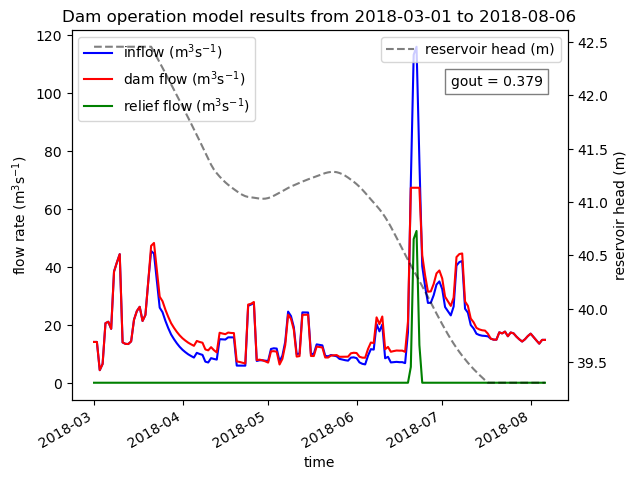

           inflow           x           w           r
count  159.000000  159.000000  159.000000  159.000000
mean    20.443239   41.069980   21.665473    0.088648
std     12.059801    0.900542   11.844598    0.981970
min      6.336835   39.655042    6.858001    0.000000
25%     13.452853   40.326145   14.550120    0.000000
50%     16.940129   41.233426   17.986776    0.000000
75%     22.743202   41.580880   24.898623    0.000000
max     76.583888   42.425561   67.290381   12.256564


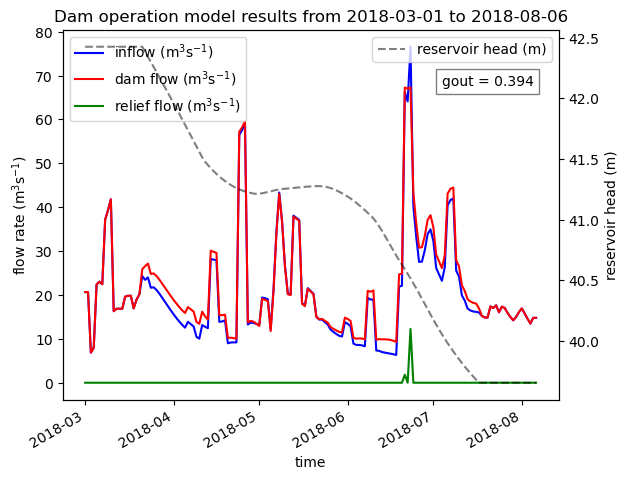

           inflow           x           w           r
count  159.000000  159.000000  159.000000  159.000000
mean    17.297794   44.156818   12.035624    0.313668
std     17.540893    3.937207   14.715769    2.825612
min      4.039219   41.553447  -18.806681    0.000000
25%      7.880803   41.662435    4.922384    0.000000
50%     11.653061   41.950569   10.130782    0.000000
75%     20.395608   45.663661   15.471690    0.000000
max    122.044879   52.120980   67.290381   29.027013


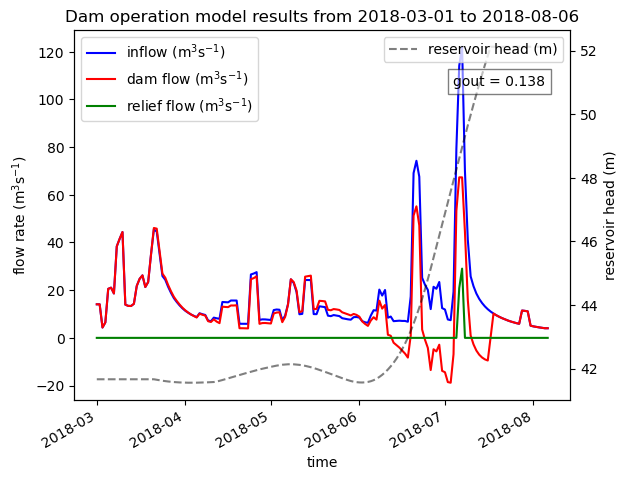

           inflow           x           w           r
count  159.000000  159.000000  159.000000  159.000000
mean    22.174064   44.075533   14.762927    2.737255
std     30.990326    3.824329   15.778533   18.200998
min      5.037728   41.144877  -14.206763    0.000000
25%      9.445006   41.388791    6.909880    0.000000
50%     15.051316   41.698087   12.355542    0.000000
75%     21.239931   46.593224   19.748809    0.000000
max    238.636307   51.372553   67.290381  151.855556


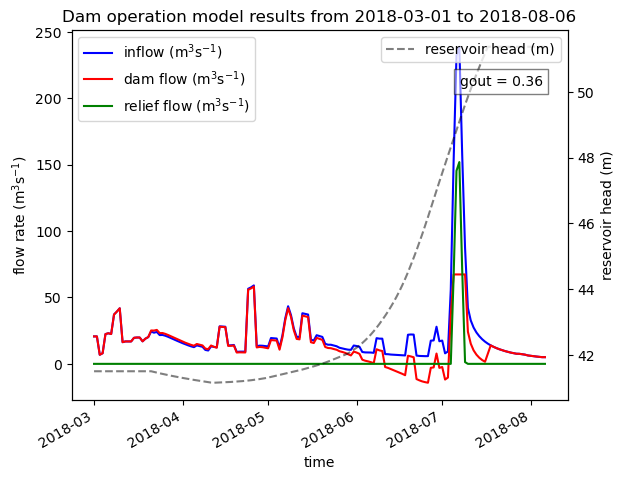

In [92]:
# now we want to plot the results
# so we want to call the dam_model function four times, once for each of the runoff arrays

# set up the start and end dates
start_date = '2018-03-01'
end_date = '2018-08-06'

# set up the figure names
fig_names = ['ERA5_S2S_gridbox_Q6_optimization', 'ERA5_S2S_point_Q6_optimization', 'ERA5_gridbox_full_Q6_optimization', 'ERA5_point_full_Q6_optimization']

# run the dam_model function for each of the runoff arrays
for i in range(len(runoffarrs)):
    dam_model(start_date, end_date, inflow_arr[i], x_arr[i], w_arr[i], r_arr[i], gout_arr[i], fig_names[i])
   